In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries

In [ ]:
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/Shareddrives/ProgettoHLT/FakeNewsDetection')

In [ ]:
import numpy as np
import seaborn as sns
import codecs
from tqdm import tqdm
from keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, GRU, Dropout, MaxPooling1D, Embedding, BatchNormalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from decimal import Decimal
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of unique words:  123659


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of news: 16646
Median length of the news: 317


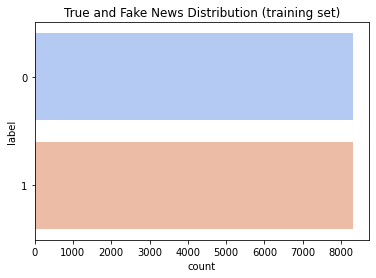

Number of True News in the Training Set: 8323
Number of Fake News in the Training Set: 8323


In [ ]:
from data_preprocessing_fulldataset import unique_words, padded_train, padded_test, Y_train, Y_test, median, word_index

# Best Model

Pre-trained Word Embedding with FastText

In [ ]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('/content/drive/Shareddrives/ProgettoHLT/FakeNewsDetection/wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


999995it [01:05, 15271.25it/s]

found 999995 word vectors


In [ ]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(unique_words, len(word_index))+1
embedding_matrix = np.zeros((nb_words, 300))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 59785


In [ ]:
best_model = Sequential()

best_model.add(Embedding(nb_words, output_dim = 300, input_length=median, weights=[embedding_matrix])) 

best_model.add(GRU(64))
best_model.add(BatchNormalization())
best_model.add(Dropout(0.1))

best_model.add(Dense(128, activation="relu"))
best_model.add(Dense(1, activation='sigmoid'))

best_model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1), loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 317, 300)          35958600  
                                                                 
 gru (GRU)                   (None, 64)                70272     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

# Best Model Retraining on full dataset

In [ ]:
# Train loss achieved with Model Selection
train_thold = 0.0658

In [ ]:
# Stopping criterion (Retrain until the loss is above the threshold)

class SOMT(Callback):

    def __init__(self, model,  train_thold):
        super(SOMT, self).__init__()
        self.model=model        
        self.train_thold=train_thold
        
    def on_epoch_end(self,epoch, logs={}): 
        tr_loss=logs.get('loss')
        if tr_loss <= self.train_thold:
            self.model.stop_training = True # stop training
            print( f'\nTraining stopped because loss reached the threshold')

In [ ]:
Y_train = np.asarray(Y_train)

In [ ]:
# Retraining Best Model
es = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)
history = best_model.fit(padded_train, Y_train, batch_size=16, epochs=30, callbacks=[es, SOMT(best_model, train_thold)])

Epoch 1/30
1041/1041 [==============================] - 38s 33ms/step - loss: 0.3856 - accuracy: 0.8247
Epoch 2/30
1041/1041 [==============================] - 33s 32ms/step - loss: 0.0833 - accuracy: 0.9761
Epoch 3/30
1041/1041 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9932
Training stopped because loss reached the threshold
1041/1041 [==============================] - 33s 32ms/step - loss: 0.0263 - accuracy: 0.9932


In [ ]:
best_ep = np.argmin(history.history["loss"][:-1])+1

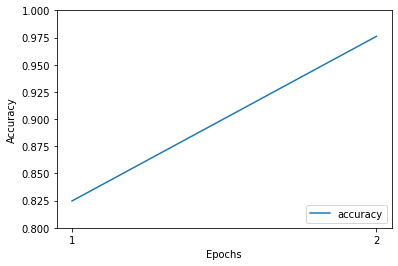

In [ ]:
#Accuracy plot
plt.plot(history.history["accuracy"][0:best_ep], label='accuracy')       
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.8,1])
plt.xticks(np.arange(len(history.history["accuracy"][0:best_ep])), np.arange(1, len(history.history["accuracy"][0:best_ep])+1))
plt.legend(loc = 'lower right')

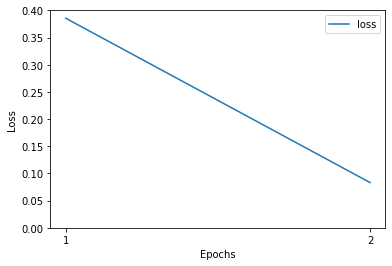

In [ ]:
#Loss plot
plt.plot(history.history["loss"][0:best_ep], label='loss')       
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,0.4])
plt.xticks(np.arange(len(history.history["loss"][0:best_ep])), np.arange(1, len(history.history["loss"][0:best_ep])+1))
plt.legend(loc = 'upper right')

# Best Model Performance on Test Set


## Classification Threshold 0.50

In [ ]:
pred = (best_model.predict(padded_test) > 0.5)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9877    0.9763    0.9820      1979
           1     0.9774    0.9883    0.9828      2056

    accuracy                         0.9824      4035
   macro avg     0.9826    0.9823    0.9824      4035
weighted avg     0.9825    0.9824    0.9824      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  98.24 %


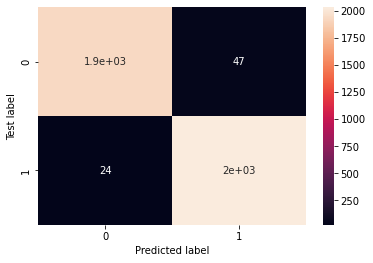

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting The Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

# Best Model Performance on Test Set with different Classification Thresholds

## Classification Threshold 0.80

In [ ]:
pred = (best_model.predict(padded_test) > 0.8)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9813    0.9823    0.9818      1979
           1     0.9830    0.9820    0.9825      2056

    accuracy                         0.9822      4035
   macro avg     0.9821    0.9822    0.9821      4035
weighted avg     0.9822    0.9822    0.9822      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  98.22 %


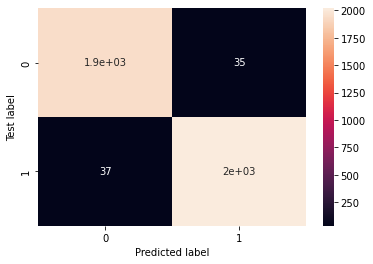

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

## Classification Threshold 0.90

In [ ]:
pred = (best_model.predict(padded_test) > 0.9)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9765    0.9869    0.9817      1979
           1     0.9872    0.9771    0.9822      2056

    accuracy                         0.9819      4035
   macro avg     0.9819    0.9820    0.9819      4035
weighted avg     0.9820    0.9819    0.9819      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  98.19 %


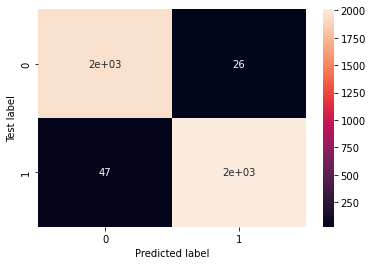

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

## Classification Threshold 0.95

In [ ]:
pred = (best_model.predict(padded_test) > 0.95)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9694    0.9929    0.9810      1979
           1     0.9930    0.9698    0.9813      2056

    accuracy                         0.9812      4035
   macro avg     0.9812    0.9814    0.9812      4035
weighted avg     0.9814    0.9812    0.9812      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  98.12 %


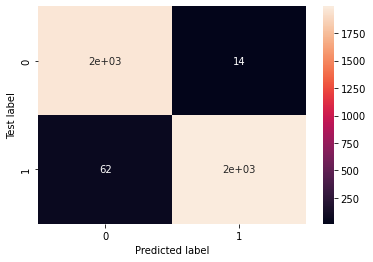

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

## Classification Threshold 0.99

In [ ]:
pred = (best_model.predict(padded_test) > 0.99)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9372    0.9955    0.9654      1979
           1     0.9953    0.9358    0.9647      2056

    accuracy                         0.9651      4035
   macro avg     0.9663    0.9656    0.9651      4035
weighted avg     0.9668    0.9651    0.9650      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  96.51 %


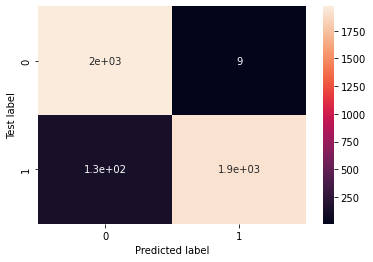

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()